In [101]:
from oceanrl import query
import matplotlib.pyplot as plt
import numpy as np
import copy
from typing import Callable, Tuple, List, Optional
from tqdm import tqdm
import time

# Analysis

## Salmon Caught versus Fishing Effort

C:\Users\pakke\AppData\Local\Temp\ipykernel_62840\84009648.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


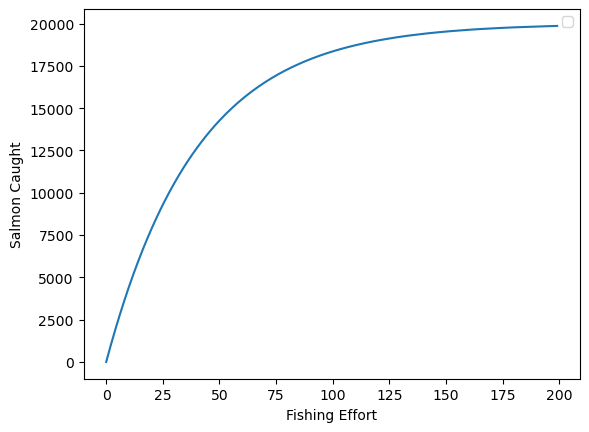

In [143]:
# The numbers for b (salmon) and c (sharks) should fluctuate slightly due to
# inherent randomness in reproduction, to provide overfitting or cheating
x = []
y = []

for i in range(200):
    x.append(i)
    a, b, c = query(20000, 500, i, 1)
    y.append(a)
    #print(a, b, c)

plt.plot(x, y)

plt.xlabel('Fishing Effort')
plt.ylabel('Salmon Caught')
plt.legend()
plt.show()

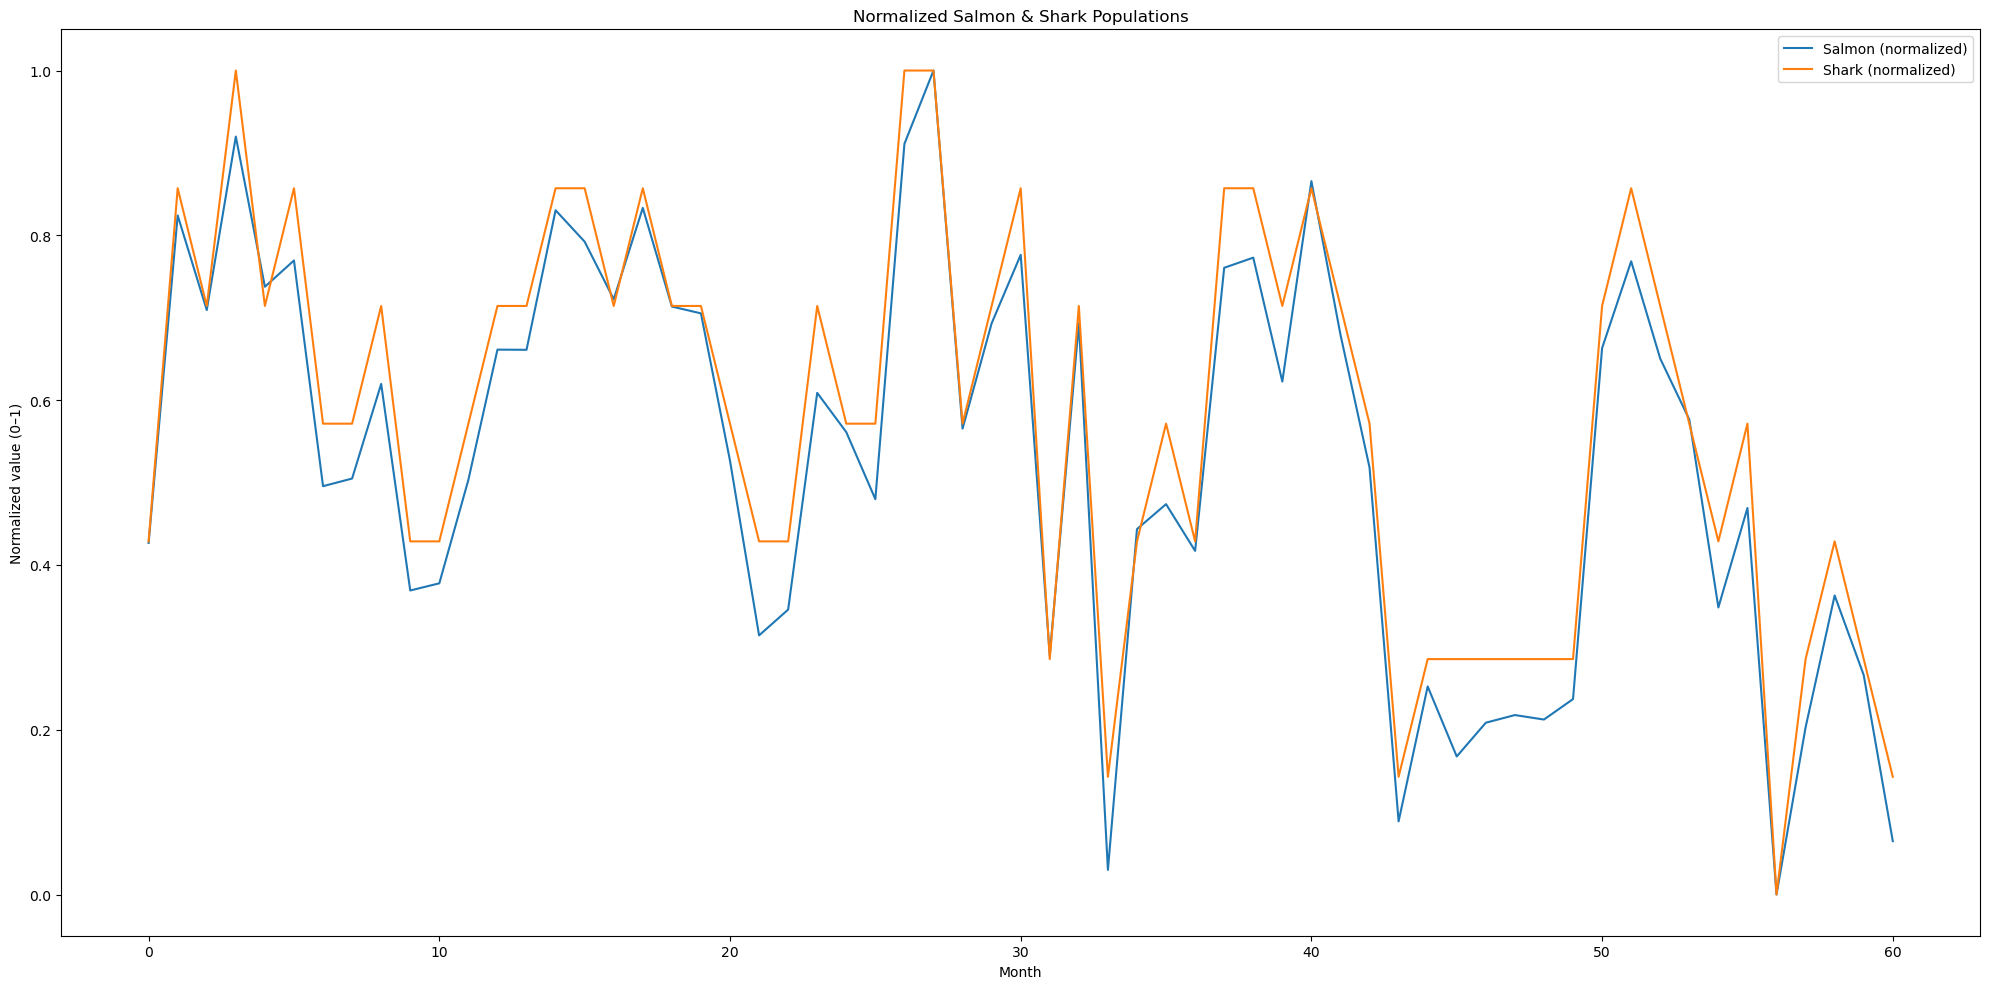

In [103]:
salmons_history = []
sharks_history = []
x = []

salmon_t = 20000
shark_t = 500
end_t = 60
effort = 0

for i in range(end_t+1):
    x.append(i)
    salmon_caught_t, salmon_t_plus_1, shark_t_plus_1 = query(salmon_t, shark_t, effort, i)    
    salmons_history.append(salmon_t_plus_1)
    sharks_history.append(shark_t_plus_1)
    
salmons_arr = np.asarray(salmons_history, dtype=float)
sharks_arr  = np.asarray(sharks_history, dtype=float)
x_arr       = np.asarray(x)

def minmax_norm(arr):
    a_min, a_max = np.min(arr), np.max(arr)
    return (arr - a_min) / (a_max - a_min) if a_max > a_min else np.zeros_like(arr)

salmons_norm = minmax_norm(salmons_arr)
sharks_norm  = minmax_norm(sharks_arr)

plt.figure(figsize=(20, 10))
plt.plot(x_arr, salmons_norm, label='Salmon (normalized)')
plt.plot(x_arr, sharks_norm,  label='Shark (normalized)')
plt.xlabel('Month')
plt.ylabel('Normalized value (0–1)')
plt.title('Normalized Salmon & Shark Populations')
plt.legend()
plt.tight_layout()
plt.show()

## Relationship between Salmon and Shark Growth without Human Interruption

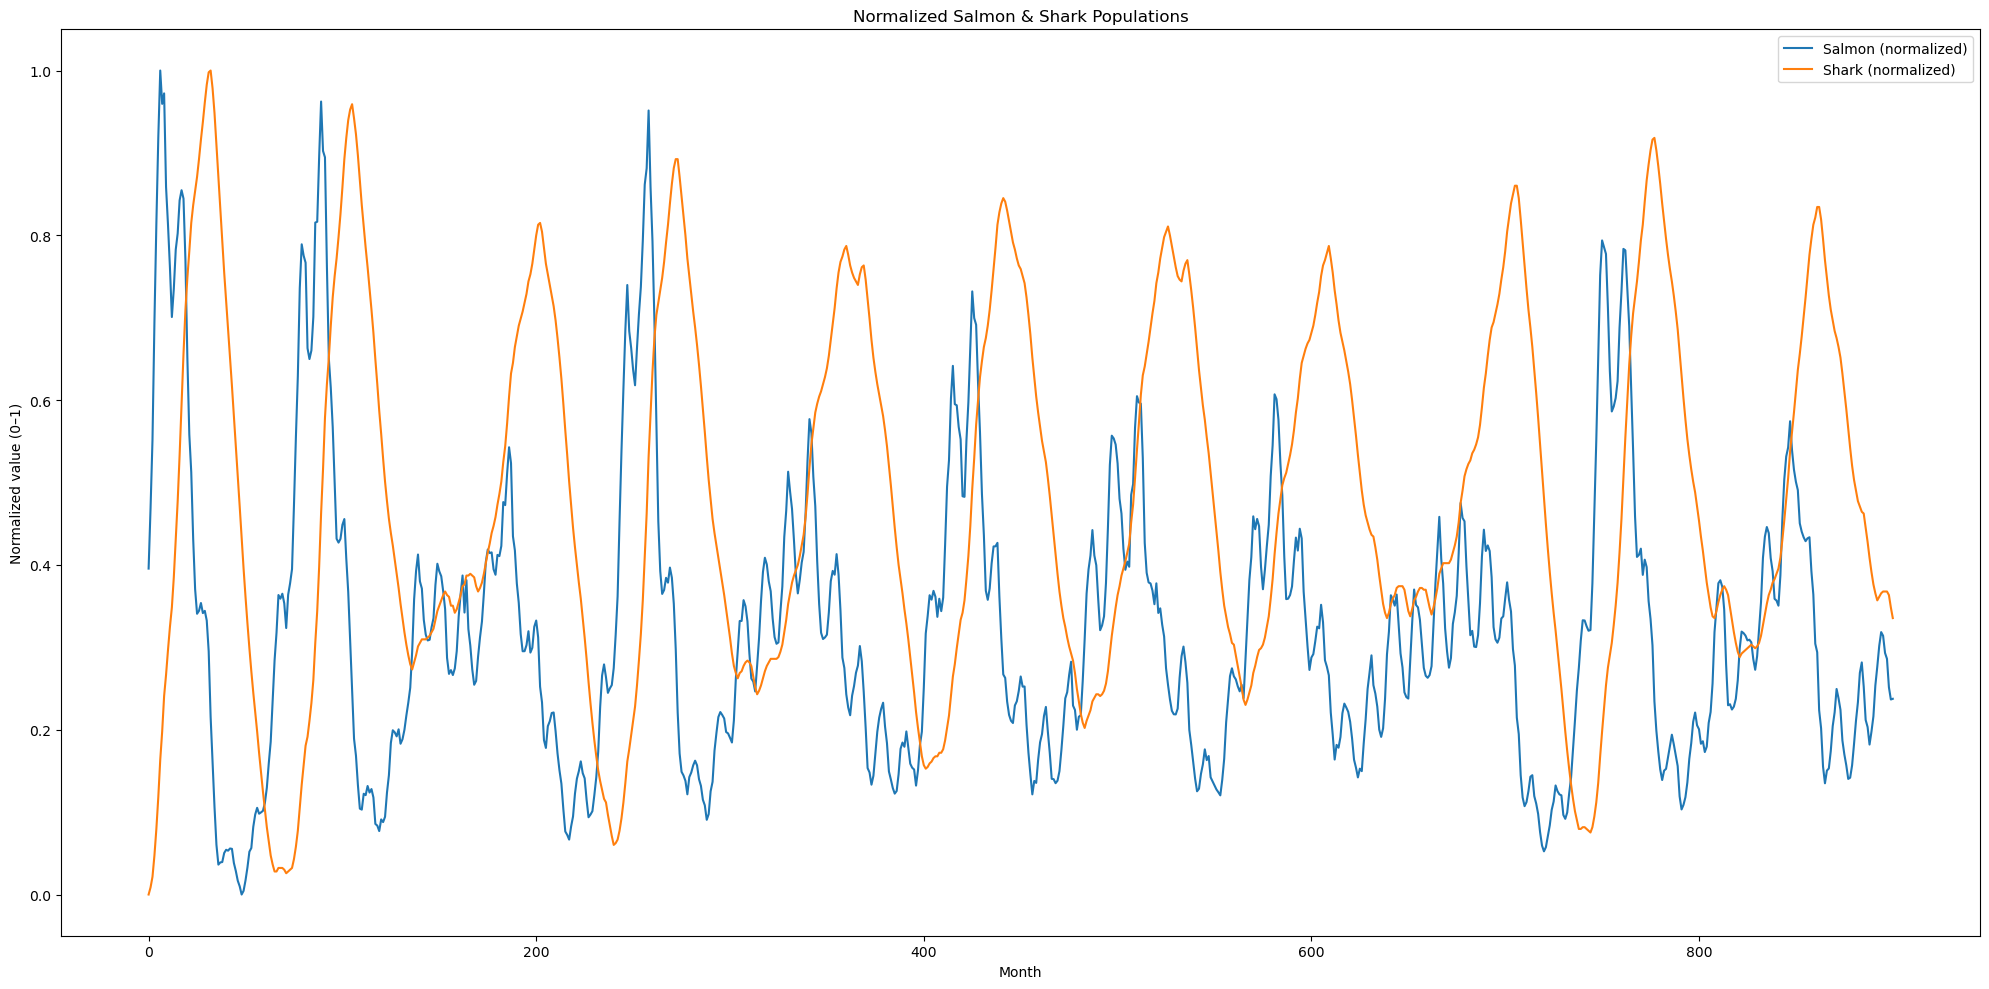

In [104]:
salmons_history = []
sharks_history = []
x = []

salmon_t = 20000
shark_t = 500
end_t = 900
effort = 0

for i in range(end_t+1):
    x.append(i)
    salmon_caught_t, salmon_t_plus_1, shark_t_plus_1 = query(salmon_t, shark_t, effort, i)    
    salmons_history.append(salmon_t)
    sharks_history.append(shark_t)
    salmon_t, shark_t = salmon_t_plus_1, shark_t_plus_1

salmons_arr = np.asarray(salmons_history, dtype=float)
sharks_arr  = np.asarray(sharks_history, dtype=float)
x_arr       = np.asarray(x)

def minmax_norm(arr):
    a_min, a_max = np.min(arr), np.max(arr)
    return (arr - a_min) / (a_max - a_min) if a_max > a_min else np.zeros_like(arr)

salmons_norm = minmax_norm(salmons_arr)
sharks_norm  = minmax_norm(sharks_arr)

plt.figure(figsize=(20, 10))
plt.plot(x_arr, salmons_norm, label='Salmon (normalized)')
plt.plot(x_arr, sharks_norm,  label='Shark (normalized)')
plt.xlabel('Month')
plt.ylabel('Normalized value (0–1)')
plt.title('Normalized Salmon & Shark Populations')
plt.legend()
plt.tight_layout()
plt.show()

1. We don't know the transitional probability
2. The state space is infinite but we can make bounded approximation

# Implementation

## Define a Agent Class using Monte Carlos Approach (Baseline)
### (Optimistic and On-Policy Agent)

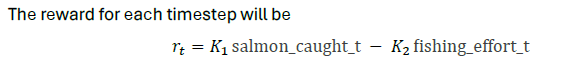
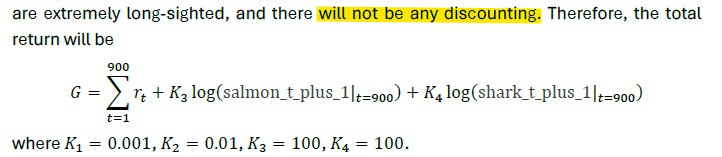

In [105]:
class SampleAgent:
    """
    Simple episodic agent with discretized state (salmon, shark, month) and
    ε-greedy policy over a tabular value function v_s.

    You must provide `env_step(salmon, shark, effort, month) -> (reward, salmon_tp1, shark_tp1)`.
    """
    def __init__(
        self,
        salmon_t0: float,
        shark_t0:float,
        env_step: Callable[[float, float, float, int], Tuple[float, float, float]],
        *,
        max_fishing_effort: float = 15.0,
        salmon_bins: int = 20,
        shark_bins: int = 20,
        action_bins: int = 20,
        max_month: int = 900,
        K1: float = 0.001,
        K2: float = 0.01,
        K3: float = 100,
        K4: float = 100,
        gamma: float = 1.0,
        epsilon: float = 0.1,
        epsilon_b: float = 0.3,
        # learning rate schedule (for Q-learning)
        alpha: float = 0.5
    ):
        self.max_month = 900
        
        self.salmon_t0 = salmon_t0
        self.shark_t0 = shark_t0
        self.t0 = 1 # month start at 1        
        self.initial_state = [self.salmon_t0, self.shark_t0, self.t0]

        # Spaces / hyperparams
        self.max_fishing_effort = max_fishing_effort
        self.salmon_bins = salmon_bins
        self.shark_bins = shark_bins
        self.action_bins = action_bins
        self.max_month = max_month
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_b = epsilon_b
        self.alpha = float(alpha)
        
        # Reward contants
        self.K1 = K1
        self.K2 = K2
        self.K3 = K3
        self.K4 = K4
        
        self.action_space = np.arange(0, self.action_bins)

        # --- tables ---
        # Q(s,a): [salmon_bins, shark_bins, max_month, action_bins]
        self.q_sa = np.full((self.salmon_bins, self.shark_bins, self.max_month, self.action_bins), np.inf, dtype=np.float64)
        
        # V(s) optional (not required for control, but you had it)
        self.v_s = np.full((self.salmon_bins, self.shark_bins, self.max_month), np.inf, dtype=np.float64)

        # visit counters
        self.n_s  = np.zeros((self.salmon_bins, self.shark_bins, self.max_month), dtype=np.float64)
        self.n_sa = np.zeros((self.salmon_bins, self.shark_bins, self.max_month, self.action_bins), dtype=np.float64)

        # logging
        self.avg_q_history: List[float] = []

        # env hookup
        self.env_step = env_step

    # ----------------- persistence -----------------
    def save_tables(self, path: str) -> None:

        meta = dict(
            salmon_bins=self.salmon_bins,
            shark_bins=self.shark_bins,
            action_bins=self.action_bins,
            max_month=self.max_month,
            version=1
        )
        np.savez_compressed(
            path,
            q_sa=self.q_sa,
            v_s=self.v_s,
            n_s=self.n_s,
            n_sa=self.n_sa,
            avg_q_history=np.asarray(self.avg_q_history, dtype=np.float64),
            **{f"meta_{k}": np.array(v) for k, v in meta.items()}
        )

    def load_tables(self, path: str, strict: bool = True) -> None:
        
        data = np.load(path, allow_pickle=False)
        def meta(k):  # helper to read tiny meta scalars
            return int(np.asarray(data[f"meta_{k}"]))

        # basic compatibility check
        sb, kb, ab, mm = meta("salmon_bins"), meta("shark_bins"), meta("action_bins"), meta("max_month")
        if strict:
            assert (sb, kb, ab, mm) == (self.salmon_bins, self.shark_bins, self.action_bins, self.max_month), \
                f"Shape mismatch. Saved=({sb},{kb},{ab},{mm}) vs current=({self.salmon_bins},{self.shark_bins},{self.action_bins},{self.max_month})"

        # load arrays (with optional safe slicing when strict=False)
        def fit(dst_shape, arr):
            if strict:
                return arr
            # slice to min shape along each dimension
            mins = tuple(min(a, b) for a, b in zip(dst_shape, arr.shape))
            slices = tuple(slice(0, m) for m in mins)
            out = np.full(dst_shape, np.inf if arr.dtype==np.float64 else 0, dtype=arr.dtype)
            out[slices] = arr[slices]
            return out

        self.q_sa = fit(self.q_sa.shape, data["q_sa"])
        self.v_s  = fit(self.v_s.shape,  data["v_s"])
        self.n_s  = fit(self.n_s.shape,  data["n_s"])
        self.n_sa = fit(self.n_sa.shape, data["n_sa"])

        if "avg_q_history" in data:
            self.avg_q_history = data["avg_q_history"].astype(np.float64).tolist()
            
        # External environment step function
        self.env_step = env_step

    def reset_env(self) -> Tuple[Tuple[float,float,int], Tuple[int,int,int]]:
        """Resets to initial state and returns (continuous_state, binned_state)."""
        self.state = self.initial_state
        self.state_bin = self._discretize(self.initial_state)        
        return self.state, self.state_bin

    def run_mc(self, episodes: int = 2000, progress_every: int = 200, on_policy=True):
        self.avg_q_history.clear()        
        with tqdm(total=episodes, desc="Episodes", leave=True) as pbar:
            avg_q = 0.0
            visited = 0.0
            coverage = 0.0
            # track binary visits for true coverage
            visited_mask = (self.n_sa > 0)
    
            for ep in range(1, episodes + 1):
                # First-Visit MC returns (backward pass)
                G = 0.0
                W = 1  # Importance sampling ratio
                seen = set()
            
                traj = self.sample_episode(on_policy=on_policy)
                for t in reversed(range(len(traj))):
                    (s, s_bin, a_bin, r_t) = traj[t]
                    #print(s, s_bin, a_bin, r_t)
                    G = r_t + self.gamma * G
    
                    key = (s_bin, a_bin)
                    if key in seen:
                        continue
                    seen.add(key)
    
                    si, ki, mi = s_bin
                    mi -= 1

                    s_tuple = tuple([si, ki, mi])
                    sa_tuple = tuple([si, ki, mi, a_bin])
                    
                    self.n_s[s_tuple] += W
                    self.n_sa[sa_tuple] += W
                    visited_mask[sa_tuple] = True
    
                    n = self.n_sa[sa_tuple]
                    q_old = self.q_sa[sa_tuple] if self.q_sa[sa_tuple] != np.inf else 0
                    self.q_sa[sa_tuple] = q_old + (G - q_old) * W / max(float(n), 1)

                    if not on_policy:
                        greedy_action = np.argmax(self.q_sa[s_tuple])
                    
                        if a_bin == greedy_action:
                            behavior_prob = (1 - self.epsilon_b) + self.epsilon_b / len(self.action_space)
                            target_prob = (1 - self.epsilon) + self.epsilon / len(self.action_space)
                        else:
                            behavior_prob = self.epsilon_b / len(self.action_space)
                            target_prob = self.epsilon / len(self.action_space)
                        
                        W *= target_prob / behavior_prob
                        if W == 0:
                            break
                
                self.v_s = np.max(self.q_sa, axis=3)
                mask = np.isfinite(self.q_sa)
                avg_q = self.q_sa[mask].mean() if mask.any() else np.nan
                
                self.avg_q_history.append(float(avg_q))
                
                visited = int(visited_mask.sum())
                coverage = float(visited / self.n_sa.size)
                pbar.set_postfix(avg_q=f"{avg_q:.4f}",
                                 visited=f"{visited}",
                                 coverage=f"{coverage:.2%}",
                                 refresh=True)
                pbar.update(1)
            return avg_q, coverage

    # ---------- Policy ----------
    def policy(self, state_bin: Tuple[int,int,int], epsilon: float = None) -> int:
        epsilon = self.epsilon if epsilon is None else float(epsilon)
        if np.random.rand() < epsilon:
            return np.random.choice(len(self.action_space))
        si, ki, mi = state_bin
        mi -= 1
        row = self.q_sa[si, ki, mi, :]
        best = row.max()
        best_actions = np.flatnonzero(row == best)
        return int(np.random.choice(best_actions))

    def behavior_policy(self, state_bin: Tuple[int,int,int]) -> int:
        return self.policy(state_bin, epsilon = self.epsilon_b)
        
    def sample_episode(self, on_policy=True) -> list(Tuple[Tuple[float,float,int], int, float]):
        """
        Roll out an episode using the current policy.
        Returns a list of (state, action, reward).
        """
        episode = []
        state, state_bin = self.reset_env()
        
        done = False
        while not done:
            if on_policy:
                a_bin = self.policy(state_bin)
            else:
                a_bin = self.behavior_policy(state_bin)
            
            #a_bin = np.random.choice(len(self.action_space)) if random else self.policy(state_bin)

            # step the environment
            reward_t, next_state, next_state_bin, done = self.transition(state, a_bin)           
            episode.append((state, state_bin, a_bin, reward_t))
            state, state_bin = next_state, next_state_bin       
        return episode
        
    def transition(self, state: Tuple[float, float, int], action_bin: int):
        """
        Environment transition wrapper: returns (reward, next_state_cont, next_state_bin, done).
        """
        done = False                    
        (salmon_t, shark_t, month_t) = state

        # Map discrete action to continuous fishing effort (use bin midpoint)
        fishing_effort_t = self._bin_to_value(action_bin, "action", use_midpoint=True)

        # Query environment (provided function)
        salmon_caught_t, salmon_t_plus_1, shark_t_plus_1 = self.env_step(salmon_t, shark_t, fishing_effort_t, month_t)

        if month_t >= self.max_month:
            total_reward = self._reward_t(salmon_caught_t, fishing_effort_t) + self._terminal_reward(salmon_t_plus_1, shark_t_plus_1)
            return total_reward, None, None, True

        month_tp1 = month_t + 1
        next_state = (salmon_t_plus_1, shark_t_plus_1, month_tp1)
        next_state_bin = self._discretize(next_state)
        reward_t = self._reward_t(salmon_caught_t, fishing_effort_t)

        return reward_t, next_state, next_state_bin, done
        
    # --- helper for terminal reward ---
    def _terminal_reward(self, salmon_t: float, shark_t: float) -> float:
        return (self.K3 * np.log(salmon_t + 1e-10) +
            self.K4 * np.log(shark_t + 1e-10)
        )
        
    def _reward_t(self, salmon_caught_t: int, fishing_effort_t: int) -> float:
        return self.K1 * salmon_caught_t - self.K2 * fishing_effort_t

    # ---------- Binning helpers ----------    
    def _discretize(self, state):
        """Map continuous (salmon, shark, month) to bins; month is clamped."""
        (salmon, shark, month) = state
        
        # choose sensible max ranges for clipping (adjust to your env)
        S_MAX = max(self.salmon_t0 * 5, 1e-9)
        K_MAX = max(self.shark_t0 * 2, 1e-9)
        #A_MAX = self.max_fishing_effort

        s_ratio = np.clip(salmon / S_MAX, 0.0, 0.999999) # 1.0 would map to out-of-range
        k_ratio = np.clip(shark / K_MAX, 0.0, 0.999999)
        
        s_bin = int(np.floor(self.salmon_bins * s_ratio))
        k_bin = int(np.floor(self.shark_bins * k_ratio))
        m_clamped = int(np.clip(month, 1, self.max_month))  # keep 1-based month for readability
        #a_bin = int(np.clip(np.floor(self.action_bins  * shark  / A_MAX), 0, self.action_bins-1))
        return (s_bin, k_bin, m_clamped)
        
    def _bin_to_value(self, bin_idx: int, attribute: str = "salmon", use_midpoint: bool =True) -> float:
        if attribute == "salmon":
            max_val = self.salmon_t0
            bins = self.salmon_bins
        elif attribute == "shark":
            max_val = self.shark_t0
            bins = self.shark_bins
        elif attribute == "action":
            max_val = self.max_fishing_effort
            bins = self.action_bins
        else:
            raise ValueError(f"Unknown attribute: {attribute}")

        # Compute bin edges
        bin_width = max_val / bins
        if use_midpoint:
            return (bin_idx + 0.5) * bin_width
        else:
            return bin_idx * bin_width
        
    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self._bin_to_value(np.random.choice(len(self.action_space)), "action", use_midpoint=True)
        salmon_t, shark_t, month_t = state
        si, ki, mi = self._discretize(state)
        mi -= 1
        q_a_max = np.argmax(self.q_sa[si, ki, mi, :])
        #print(self.q_sa[si, ki, mi, :])
        fishing_effort_t = self._bin_to_value(q_a_max, "action", use_midpoint=True)
        return fishing_effort_t

## Find the Optimal Max Fishing Effort

In [147]:
salmon_t = 20000
shark_t = 500

coverage_all_effort = {}
avg_q_all_effort = {}

for e in range(0, 50, 4):
    print(f"Max Fishing Effort: {e}")
    agent = SampleAgent(salmon_t, shark_t, query, max_fishing_effort=e, gamma=1.0, epsilon=0.15)
    avg_q, coverage = agent.run_mc(episodes = 500, progress_every = 200, on_policy=True)
    avg_q_all_effort[e] = avg_q
    coverage_all_effort[e] = coverage

Max Fishing Effort: 0


Episodes: 100%|█| 500/500 [00:52<00:00,  9.48it/s, avg_q=1583.6561, coverage=1.84%, v


Max Fishing Effort: 4


Episodes: 100%|█| 500/500 [00:47<00:00, 10.60it/s, avg_q=1931.7655, coverage=2.08%, v


Max Fishing Effort: 8


Episodes: 100%|█| 500/500 [00:51<00:00,  9.75it/s, avg_q=2283.5538, coverage=2.56%, v


Max Fishing Effort: 12


Episodes: 100%|█| 500/500 [00:48<00:00, 10.38it/s, avg_q=2578.7715, coverage=3.18%, v


Max Fishing Effort: 16


Episodes: 100%|█| 500/500 [00:51<00:00,  9.75it/s, avg_q=2896.6292, coverage=3.65%, v


Max Fishing Effort: 20


Episodes: 100%|█| 500/500 [00:53<00:00,  9.41it/s, avg_q=3212.3156, coverage=3.97%, v


Max Fishing Effort: 24


Episodes: 100%|█| 500/500 [00:54<00:00,  9.09it/s, avg_q=3521.3838, coverage=4.18%, v


Max Fishing Effort: 28


Episodes: 100%|█| 500/500 [00:57<00:00,  8.75it/s, avg_q=3753.1078, coverage=4.27%, v


Max Fishing Effort: 32


Episodes: 100%|█| 500/500 [00:51<00:00,  9.67it/s, avg_q=4131.9121, coverage=4.75%, v


Max Fishing Effort: 36


Episodes: 100%|█| 500/500 [00:52<00:00,  9.59it/s, avg_q=3983.2177, coverage=3.02%, v


Max Fishing Effort: 40


Episodes: 100%|█| 500/500 [00:48<00:00, 10.33it/s, avg_q=3343.9558, coverage=2.50%, v


Max Fishing Effort: 44


Episodes: 100%|█| 500/500 [00:50<00:00,  9.81it/s, avg_q=1990.9493, coverage=2.22%, v


Max Fishing Effort: 48


Episodes: 100%|█| 500/500 [00:49<00:00, 10.17it/s, avg_q=873.7913, coverage=1.90%, vi


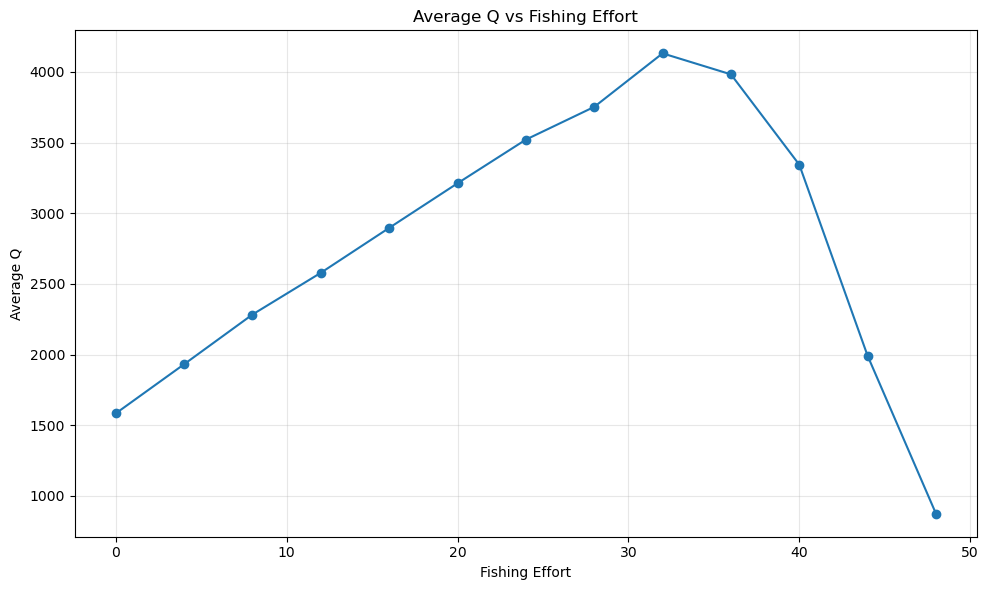

In [148]:
# Sort by effort for a clean line
x, y = zip(*sorted(avg_q_all_effort.items()))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, marker='o', linewidth=1.5)
ax.set_title("Average Q vs Fishing Effort")
ax.set_xlabel("Fishing Effort")
ax.set_ylabel("Average Q")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [108]:
salmon_t = 20000
shark_t = 500

coverage_all_effort = {}
avg_q_all_effort = {}

for e in range(0, 50, 4):
    print(f"Max Fishing Effort: {e}")
    agent = SampleAgent(salmon_t, shark_t, query, max_fishing_effort=e, gamma=1.0, epsilon=0.15)
    avg_q, coverage = agent.run_mc(episodes = 500, progress_every = 200, on_policy=False)
    avg_q_all_effort[e] = avg_q
    coverage_all_effort[e] = coverage

Max Fishing Effort: 0


Episodes: 100%|█| 500/500 [00:50<00:00,  9.84it/s, avg_q=60.9766, coverage=1.81%, vis


Max Fishing Effort: 4


Episodes: 100%|█| 500/500 [00:47<00:00, 10.61it/s, avg_q=80.2962, coverage=1.99%, vis


Max Fishing Effort: 8


Episodes: 100%|█| 500/500 [00:50<00:00,  9.88it/s, avg_q=47.0999, coverage=2.58%, vis


Max Fishing Effort: 12


Episodes: 100%|█| 500/500 [00:50<00:00,  9.95it/s, avg_q=31.5705, coverage=3.07%, vis


Max Fishing Effort: 16


Episodes: 100%|█| 500/500 [00:49<00:00, 10.02it/s, avg_q=14.7012, coverage=3.51%, vis


Max Fishing Effort: 20


Episodes: 100%|█| 500/500 [00:51<00:00,  9.75it/s, avg_q=13.0441, coverage=3.77%, vis


Max Fishing Effort: 24


Episodes: 100%|█| 500/500 [00:48<00:00, 10.29it/s, avg_q=8.5180, coverage=4.01%, visi


Max Fishing Effort: 28


Episodes: 100%|█| 500/500 [00:52<00:00,  9.46it/s, avg_q=8.8029, coverage=4.09%, visi


Max Fishing Effort: 32


Episodes: 100%|█| 500/500 [00:56<00:00,  8.79it/s, avg_q=8.5961, coverage=4.17%, visi


Max Fishing Effort: 36


Episodes: 100%|█| 500/500 [01:08<00:00,  7.28it/s, avg_q=1.5403, coverage=4.06%, visi


Max Fishing Effort: 40


Episodes: 100%|█| 500/500 [00:55<00:00,  9.01it/s, avg_q=6.8924, coverage=2.23%, visi


Max Fishing Effort: 44


Episodes: 100%|█| 500/500 [00:53<00:00,  9.30it/s, avg_q=0.7677, coverage=1.94%, visi


Max Fishing Effort: 48


Episodes: 100%|█| 500/500 [00:49<00:00, 10.14it/s, avg_q=-11.4664, coverage=1.26%, vi


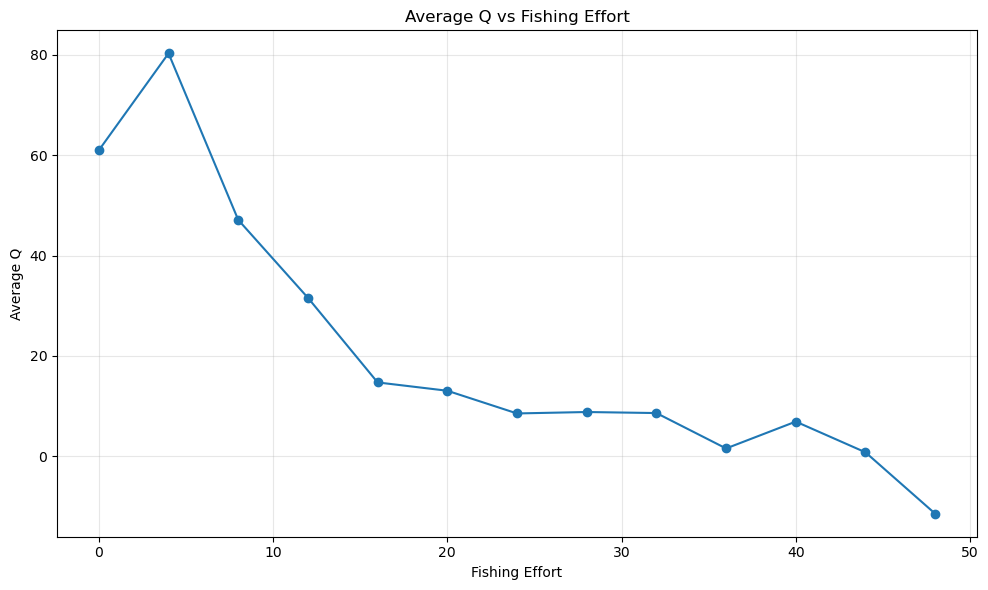

In [146]:
# Sort by effort for a clean line
x, y = zip(*sorted(avg_q_all_effort.items()))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, y, marker='o', linewidth=1.5)
ax.set_title("Average Q vs Fishing Effort")
ax.set_xlabel("Fishing Effort")
ax.set_ylabel("Average Q")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Find the Optimal Epsilon

In [110]:
E_MAX = 36  # fixed cap
salmon_t = 20000
shark_t = 500

avg_q_all_eps = {}
coverage_all_eps = {}

# e in {0.00, 0.04, 0.08, ..., 0.50}
epsilon_grid = [round(i / 100, 2) for i in range(0, 51, 4)]

for eps in epsilon_grid:
    print(f"Epsilon: {eps:.2f}")
    agent = SampleAgent(
        salmon_t, shark_t, query,
        max_fishing_effort=E_MAX,
        gamma=1.0,
        epsilon=eps
    )
    avg_q, coverage = agent.run_mc(episodes=500, progress_every=200, on_policy=True)
    avg_q_all_eps[eps] = avg_q
    coverage_all_eps[eps] = coverage

# (Optional) quick view
print("avg_q by epsilon:", {k: float(v) for k, v in avg_q_all_eps.items()})
print("coverage by epsilon:", {k: float(v) for k, v in coverage_all_eps.items()})

Epsilon: 0.00


Episodes: 100%|█| 500/500 [00:51<00:00,  9.75it/s, avg_q=4026.8092, coverage=2.70%, v


Epsilon: 0.04


Episodes: 100%|█| 500/500 [00:53<00:00,  9.27it/s, avg_q=4028.9982, coverage=3.08%, v


Epsilon: 0.08


Episodes: 100%|█| 500/500 [00:50<00:00,  9.92it/s, avg_q=4044.3039, coverage=3.06%, v


Epsilon: 0.12


Episodes: 100%|█| 500/500 [00:51<00:00,  9.70it/s, avg_q=4031.2272, coverage=3.37%, v


Epsilon: 0.16


Episodes: 100%|█| 500/500 [00:50<00:00,  9.85it/s, avg_q=3981.6132, coverage=3.15%, v


Epsilon: 0.20


Episodes: 100%|█| 500/500 [00:54<00:00,  9.16it/s, avg_q=4023.5626, coverage=3.10%, v


Epsilon: 0.24


Episodes: 100%|█| 500/500 [00:50<00:00,  9.93it/s, avg_q=4018.8597, coverage=3.08%, v


Epsilon: 0.28


Episodes: 100%|█| 500/500 [00:53<00:00,  9.29it/s, avg_q=4061.0244, coverage=3.29%, v


Epsilon: 0.32


Episodes: 100%|█| 500/500 [00:51<00:00,  9.62it/s, avg_q=3960.9647, coverage=3.21%, v


Epsilon: 0.36


Episodes: 100%|█| 500/500 [00:49<00:00, 10.16it/s, avg_q=3980.9224, coverage=3.16%, v


Epsilon: 0.40


Episodes: 100%|█| 500/500 [00:49<00:00, 10.14it/s, avg_q=4032.6881, coverage=3.32%, v


Epsilon: 0.44


Episodes: 100%|█| 500/500 [00:50<00:00,  9.90it/s, avg_q=3936.7422, coverage=3.49%, v


Epsilon: 0.48


Episodes: 100%|█| 500/500 [00:48<00:00, 10.29it/s, avg_q=4004.3253, coverage=3.45%, v

avg_q by epsilon: {0.0: 4026.8091883043576, 0.04: 4028.9982153773817, 0.08: 4044.3038803251297, 0.12: 4031.2272170534575, 0.16: 3981.613160572749, 0.2: 4023.5626224876587, 0.24: 4018.859669303713, 0.28: 4061.0244045801187, 0.32: 3960.964717587079, 0.36: 3980.9223905594467, 0.4: 4032.688116055893, 0.44: 3936.7421528351488, 0.48: 4004.325259666077}
coverage by epsilon: {0.0: 0.02700111111111111, 0.04: 0.03079986111111111, 0.08: 0.0306375, 0.12: 0.03365986111111111, 0.16: 0.03153361111111111, 0.2: 0.03104486111111111, 0.24: 0.03082361111111111, 0.28: 0.03288708333333333, 0.32: 0.03206361111111111, 0.36: 0.031572361111111114, 0.4: 0.03318625, 0.44: 0.034937083333333334, 0.48: 0.034542777777777776}


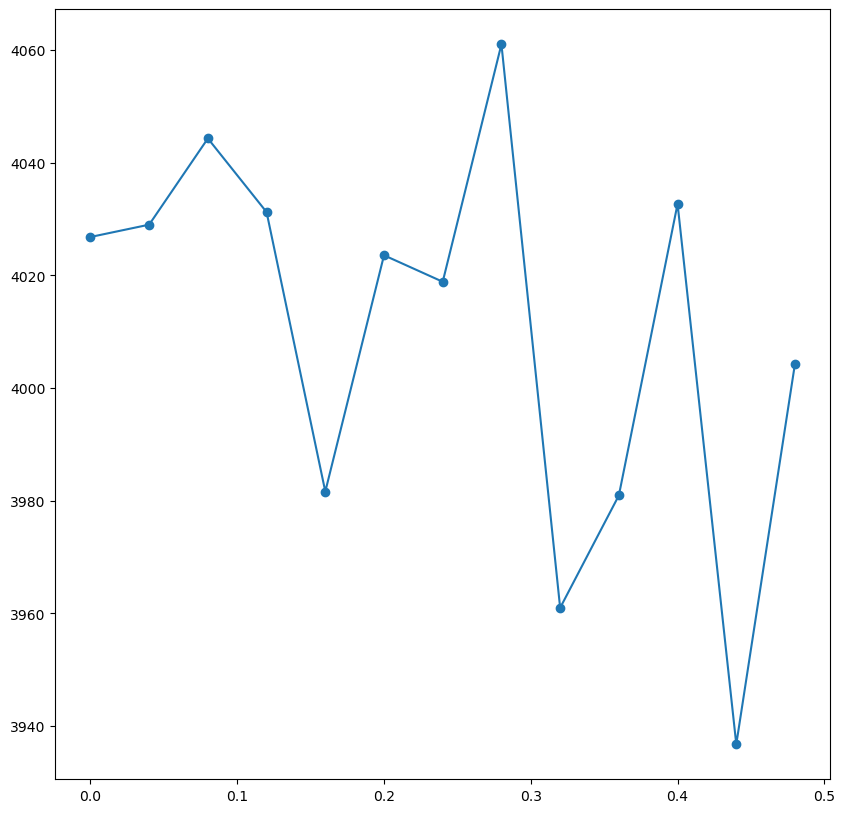

In [111]:
x = list(avg_q_all_eps.keys())
y = list(avg_q_all_eps.values())

fig = plt.figure(figsize=(10,10))
plt.plot(x, y, marker='o')
plt.show()

## Helpers

In [112]:
def plot_q_hist(agent, m: int = None):
    """
    Histogram of Q values. If m is given, use that month; else use all months.
    """
    if m is None:
        data = agent.q_sa.ravel()
        title = "Histogram of all Q(s,a)"
    else:
        mi = _to_month_idx(agent, m)
        data = agent.q_sa[:, :, mi, :].ravel()
        title = f"Histogram of Q(s,a) at month {m}"

    data = data[np.isfinite(data)]
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=50)
    plt.title(title)
    plt.xlabel("Q value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

def plot_value_by_month(agent):
    """
    Mean V(s) across states for each month, useful to see learning over horizon.
    """
    V = agent.v_s
    mean_V_by_m = np.mean(V, axis=(0, 1), where=np.isfinite(V))    

    plt.figure(figsize=(7, 3.5))
    plt.plot(np.arange(1, agent.max_month + 1), mean_V_by_m)
    plt.title("Mean V(s) by month")
    plt.xlabel("Month (t)")
    plt.ylabel("Mean V(s)")
    plt.tight_layout()
    plt.show()

def plot_q_heatmap(agent, m: int, a_bin: int):
    """
    Heatmap of Q(s,a_bin) at month m (1-based).
    """
    mi = m - 1
    a_bin = int(np.clip(a_bin, 0, agent.action_bins - 1))
    Q = agent.q_sa[:, :, mi, a_bin]

    plt.figure(figsize=(6, 5))
    im = plt.imshow(Q, origin='lower', aspect='auto')
    plt.title(f"Q(s, a={a_bin}) heatmap at month {m}")
    plt.xlabel("Shark bin (k)")
    plt.ylabel("Salmon bin (s)")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

def plot_3d_scatter_V(agent, step_salmon=1, step_shark=1, step_month=5):
    """3D scatter across (salmon bin, shark bin, month) with color = V."""
    V = agent.v_s
    S, K, M = V.shape

    s_idx = np.arange(0, S, max(1, int(step_salmon)))
    k_idx = np.arange(0, K, max(1, int(step_shark)))
    m_idx = np.arange(0, M, max(1, int(step_month)))

    SS, KK, MM = np.meshgrid(s_idx, k_idx, m_idx, indexing='ij')
    vals = V[SS, KK, MM]

    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    pts = ax.scatter(KK.ravel(), SS.ravel(), (MM.ravel()+1), c=vals.ravel(), s=10)
    ax.set_title("3D Scatter: V over (salmon bin, shark bin, month)")
    ax.set_xlabel("Shark bin")
    ax.set_ylabel("Salmon bin")
    ax.set_zlabel("Month (1-based)")
    cbar = fig.colorbar(pts, ax=ax, shrink=0.75, pad=0.1)
    cbar.set_label("V(s)")
    plt.tight_layout()
    plt.show()

def plot_policy_grid(agent, months, cols=3):
    """
    Show several months’ greedy policies in a grid.
    """
    q_sa = agent.q_sa
    S, K, M, A = q_sa.shape
    months = list(months)
    rows = int(np.ceil(len(months) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    axes = np.atleast_2d(axes)

    for idx, m in enumerate(months):
        r, c = divmod(idx, cols)
        mi = m - 1
        policy = np.argmax(q_sa[:, :, mi, :], axis=2)
        ax = axes[r, c]
        im = ax.imshow(policy, origin='lower', aspect='auto', interpolation='nearest')
        ax.set_title(f"Greedy policy at month {m}")
        ax.set_xlabel("Shark bin"); ax.set_ylabel("Salmon bin")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # hide any unused subplots
    for j in range(len(months), rows*cols):
        r, c = divmod(j, cols)
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

def coverage_at(n_sa, N=1, month=None):
    # n_sa shape: [S, K, M, A]
    arr = n_sa if month is None else n_sa[:, :, month-1:month, :]
    total = arr.size
    covered = (arr >= N).sum()
    return covered / total if total else 0.0

def evaluation(agent, salmon_t0: int = 20000, shark_t0: int = 500, episodes: int = 1000) -> Tuple[float, int, float, int, int]:
    Gs, total_salmon_caughts, total_efforts, salmon_t900s, shark_t900s = [], [], [], [], []

    for e in tqdm(range(episodes)):
        
        total_salmon_caught = 0
        total_effort = 0.0
        salmon_t = salmon_t0
        shark_t = shark_t0
        
        for month_t in range(1, 901):
            fishing_effort_t = agent.act((salmon_t, shark_t, month_t))
            salmon_caught_t, salmon_t_plus_1, shark_t_plus_1 = query(salmon_t, shark_t, fishing_effort_t, month_t)
            total_salmon_caught += salmon_caught_t
            total_effort += fishing_effort_t
            salmon_t, shark_t = salmon_t_plus_1, shark_t_plus_1
    
        K1, K2, K3, K4 = 0.001, 0.01, 100, 100
        G = K1*total_salmon_caught - K2*total_effort + K3*np.log(salmon_t+1e-10) + K4*np.log(shark_t+1e-10)

        Gs.append(G)
        total_salmon_caughts.append(total_salmon_caught)        
        total_efforts.append(total_effort)
        salmon_t900s.append(salmon_t)
        shark_t900s.append(shark_t)

    return (np.mean(Gs), np.std(Gs), np.mean(total_salmon_caughts), np.mean(total_efforts), np.mean(salmon_t900s), np.mean(shark_t900s))

## Run the MC (On-Policy)

In [114]:
salmon_t = 20000
shark_t = 500

agent_onp = SampleAgent(salmon_t, shark_t, query, max_fishing_effort=36, gamma=1.0, epsilon=0.28)
agent_onp.run_mc(episodes = 20000, progress_every = 200, on_policy=True)

Episodes: 100%|█| 20000/20000 [33:46<00:00,  9.87it/s, avg_q=4285.0168, coverage=8.94


27.900000000000002

In [115]:
print(len(agent_onp.avg_q_history), "episodes logged")
print(agent_onp.avg_q_history[:5])

# save / load
agent_onp.save_tables("agent_offp_tables.npz")

20000 episodes logged
[4797.905721409927, 3925.837231508638, 4120.278097971449, 4260.63139410864, 4344.826887600205]


In [116]:
print(agent_onp.n_sa.size)
print(agent_onp.n_sa.sum())

7200000
18000000.0


### Plot the Average Q per Episode 

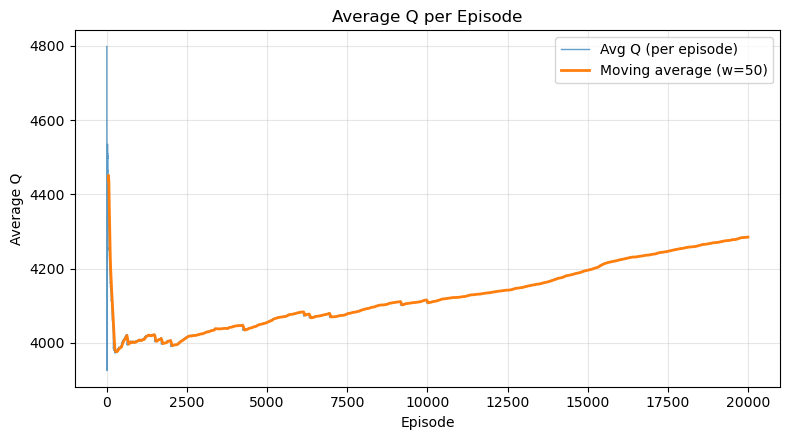

In [117]:
# Prepare data
hist = np.asarray(agent_onp.avg_q_history, dtype=float)
x = np.arange(1, hist.size + 1)

# Basic line + optional moving average
plt.figure(figsize=(8, 4.5))
plt.plot(x, hist, linewidth=1, alpha=0.7, label="Avg Q (per episode)")

# Moving average (set window as you like, e.g., 50)
window = 50
if hist.size >= window:
    # replace NaNs for smoothing only
    hist_for_smooth = np.copy(hist)
    if not np.isfinite(hist_for_smooth).all():
        hist_for_smooth[~np.isfinite(hist_for_smooth)] = np.nanmean(hist_for_smooth[np.isfinite(hist_for_smooth)])
    kernel = np.ones(window, dtype=float) / window
    smooth = np.convolve(hist_for_smooth, kernel, mode="valid")
    xs = np.arange(window, hist.size + 1)
    plt.plot(xs, smooth, linewidth=2, label=f"Moving average (w={window})")

plt.title("Average Q per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Q")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Plot the MC Results

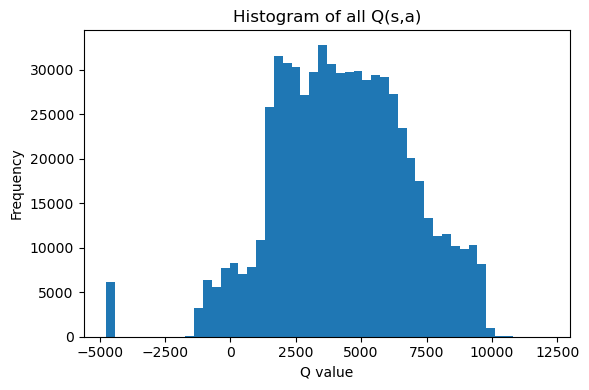

In [118]:
plot_q_hist(agent_onp)

### State-Value Function by Month

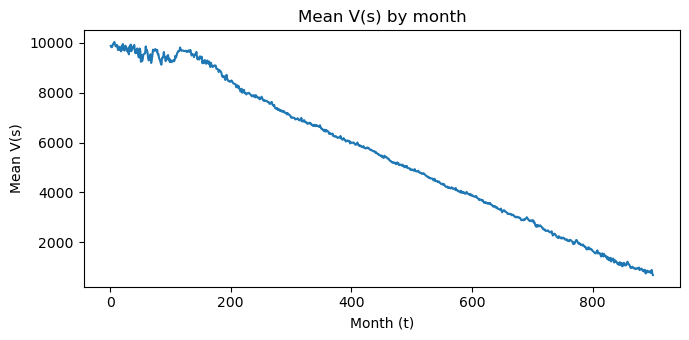

In [119]:
plot_value_by_month(agent_onp)

### 3D Heatmap of Action-Value Function 

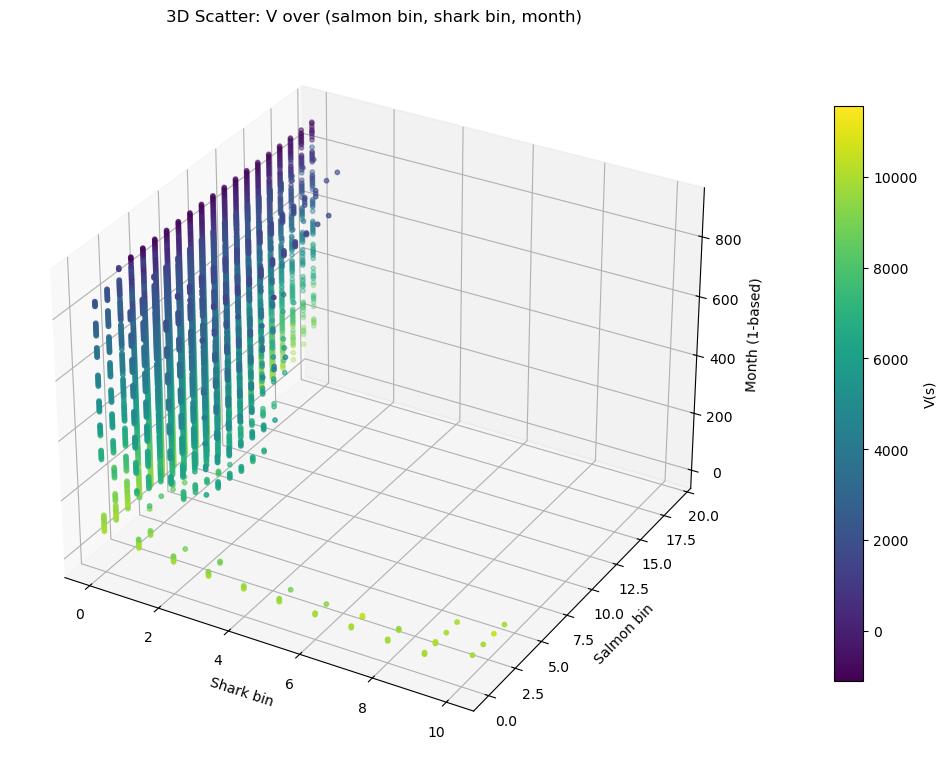

In [120]:
plot_3d_scatter_V(agent_onp)

### Policy Grid by Months

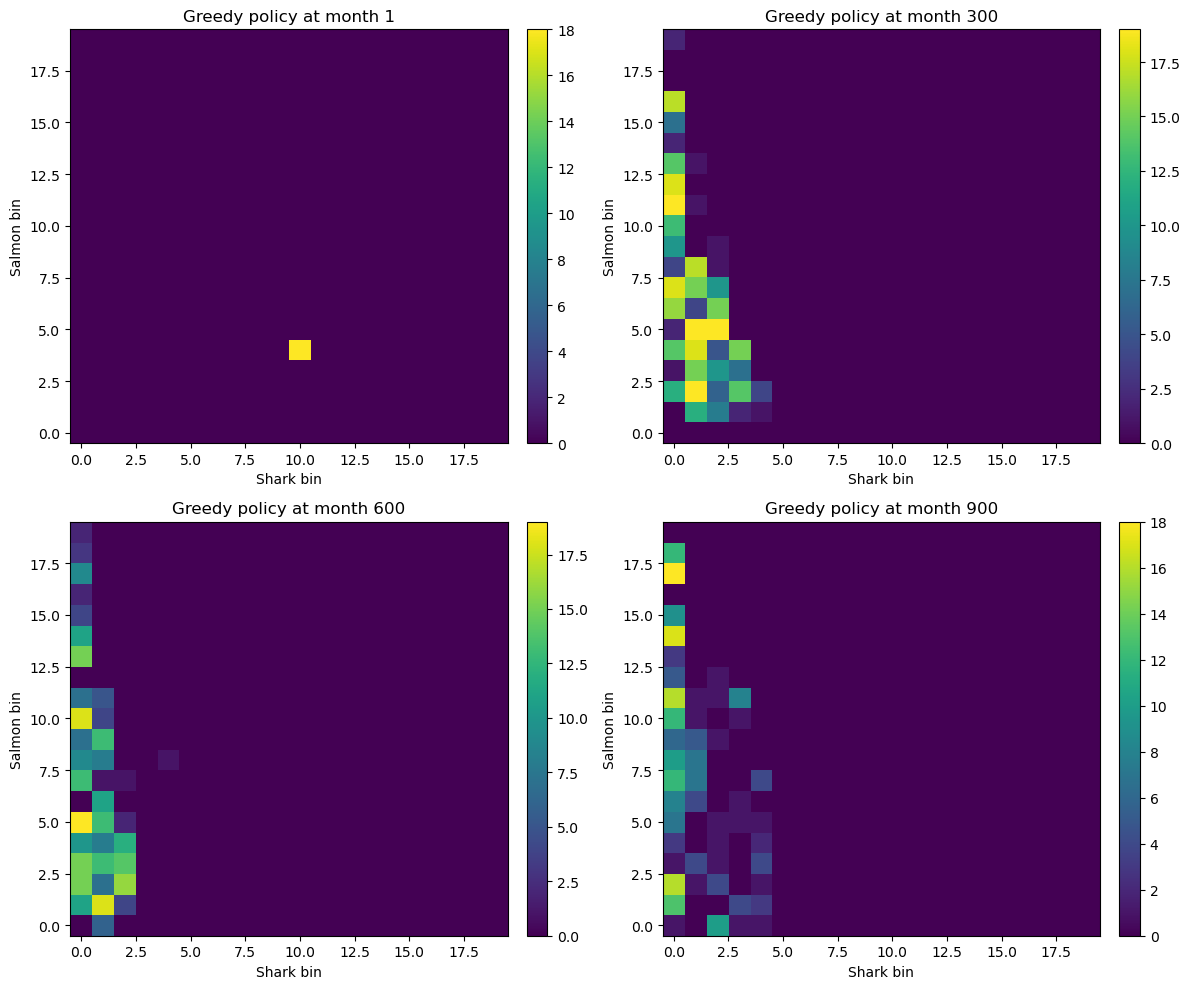

In [121]:
plot_policy_grid(agent_onp, months=[1, 300, 600, 900], cols=2)

### Check Coverage

In [122]:
cov1_all   = coverage_at(agent_onp.n_sa, N=1)     # ever visited
cov10_all  = coverage_at(agent_onp.n_sa, N=10)    # at least 10 visits
cov1_m900  = coverage_at(agent_onp.n_sa, N=1, month=900)
cov10_m900 = coverage_at(agent_onp.n_sa, N=10, month=900)

print(cov1_all)
print(cov10_all)
print(cov1_m900)
print(cov10_m900)

0.08937236111111112
0.026366666666666667
0.154125
0.03125


## Run the MC (Off-Policy)

In [123]:
salmon_t = 20000
shark_t = 500

agent_offp = SampleAgent(salmon_t, shark_t, query, max_fishing_effort=36, gamma=1.0, epsilon=0.28, epsilon_b=0.56)
agent_offp.run_mc(episodes = 20000, progress_every = 200, on_policy=False)

Episodes: 100%|█| 20000/20000 [38:29<00:00,  8.66it/s, avg_q=382.0382, coverage=11.95


(np.float64(382.038230273506), 0.11952861111111111)

In [124]:
print(len(agent_offp.avg_q_history), "episodes logged")
print(agent_offp.avg_q_history[:5])

# save / load
agent_offp.save_tables("agent_offp_tables.npz")

20000 episodes logged
[2.9267700542580086, 3.0657538602746834, 3.048992458652539, 3.0380634544140204, 1.858465293435915]


In [125]:
print(agent_offp.n_sa.size)
print(agent_offp.n_sa.sum())

7200000
8.081567250727634e+139


### Plot the Average Q per Episode 

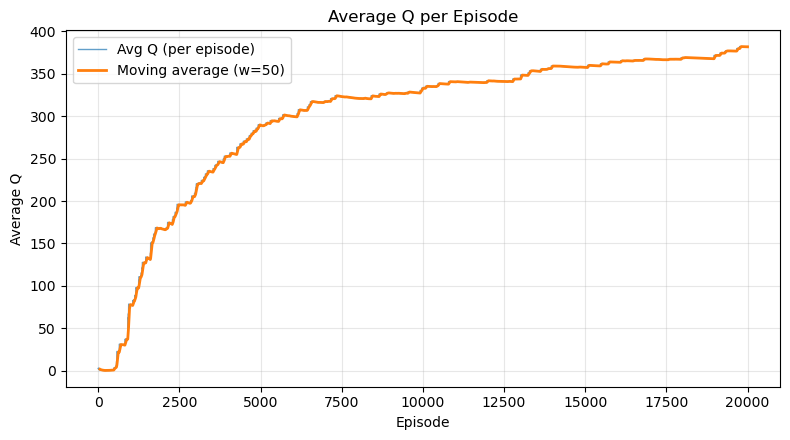

In [126]:
# Prepare data
hist = np.asarray(agent_offp.avg_q_history, dtype=float)
x = np.arange(1, hist.size + 1)

# Basic line + optional moving average
plt.figure(figsize=(8, 4.5))
plt.plot(x, hist, linewidth=1, alpha=0.7, label="Avg Q (per episode)")

# Moving average (set window as you like, e.g., 50)
window = 50
if hist.size >= window:
    # replace NaNs for smoothing only
    hist_for_smooth = np.copy(hist)
    if not np.isfinite(hist_for_smooth).all():
        hist_for_smooth[~np.isfinite(hist_for_smooth)] = np.nanmean(hist_for_smooth[np.isfinite(hist_for_smooth)])
    kernel = np.ones(window, dtype=float) / window
    smooth = np.convolve(hist_for_smooth, kernel, mode="valid")
    xs = np.arange(window, hist.size + 1)
    plt.plot(xs, smooth, linewidth=2, label=f"Moving average (w={window})")

plt.title("Average Q per Episode")
plt.xlabel("Episode")
plt.ylabel("Average Q")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Plot the MC Results

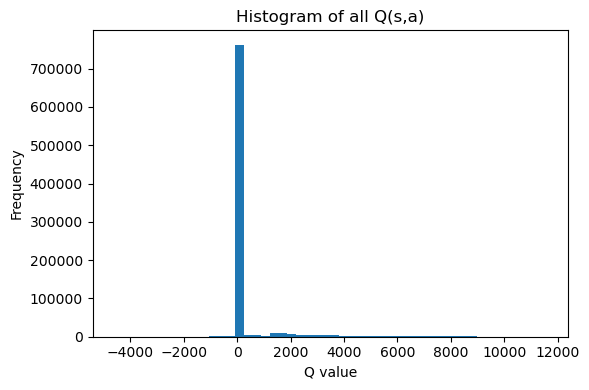

In [127]:
plot_q_hist(agent_offp)

### State-Value Function by Month

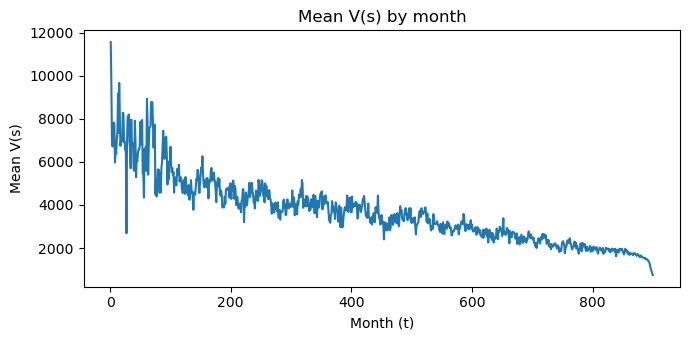

In [128]:
plot_value_by_month(agent_offp)

### 3D Heatmap of Action-Value Function 

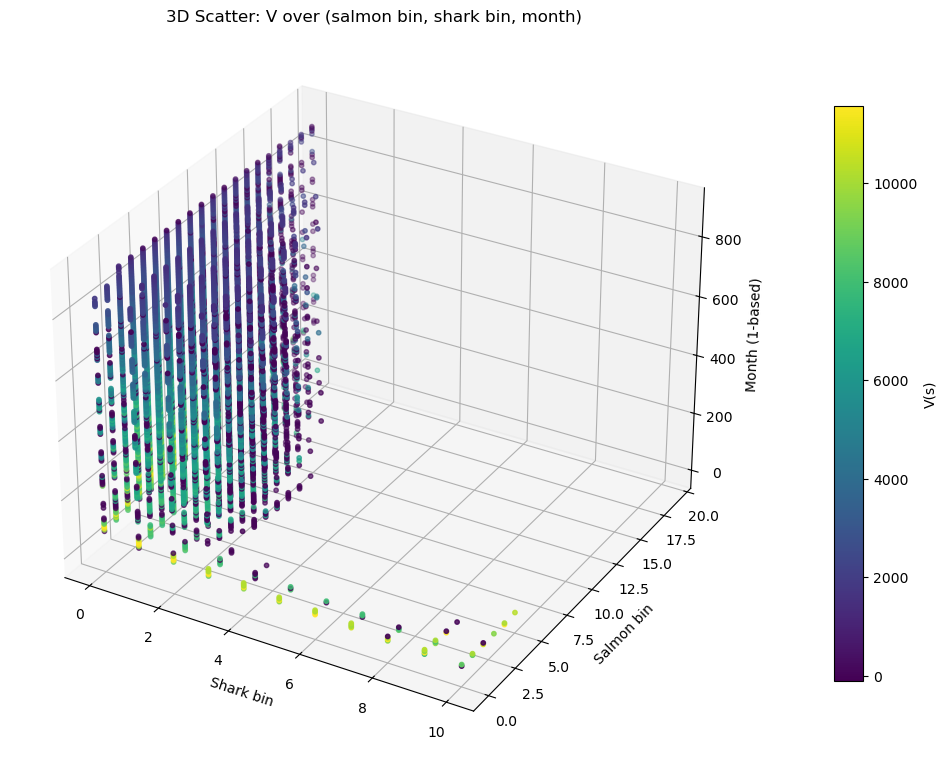

In [129]:
plot_3d_scatter_V(agent_offp)

### Policy Grid by Months

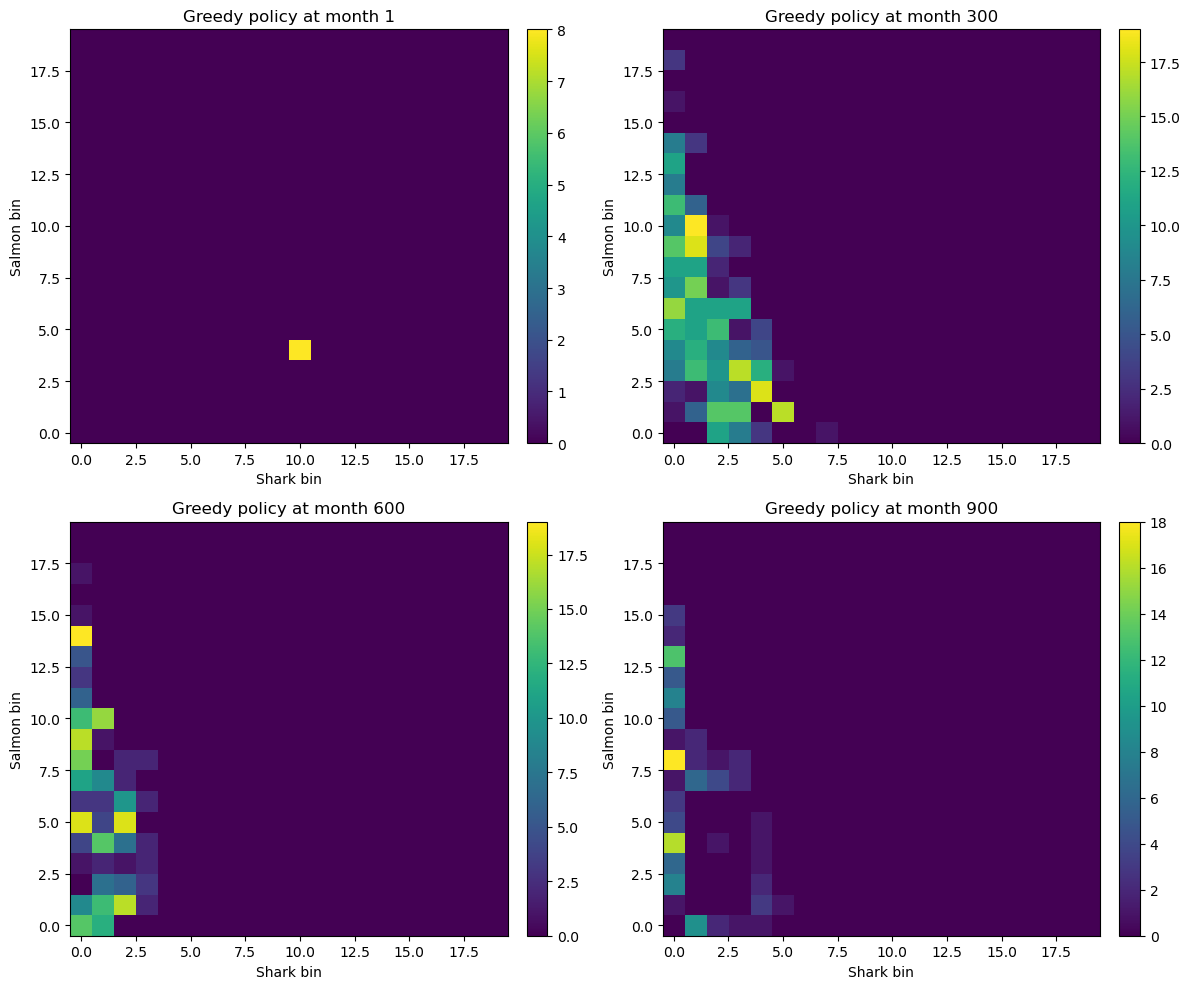

In [130]:
plot_policy_grid(agent_offp, months=[1, 300, 600, 900], cols=2)

# Comparsion of Naive Model and My MC Model

In [131]:
class NaiveAgent:
    def __init__(self):
        pass

    def act(self, state):
        salmon_t, shark_t, month_t = state
        fishing_effort_t = 8  ## Just for demo. Your marks will be capped if you use any form of rule-based method
        return fishing_effort_t

## Naive Results

In [132]:
agent = NaiveAgent()

G_mean, G_std, total_salmon_caught_mean, total_effort_mean, salmon_t900_mean, shark_t900_mean = evaluation(agent=agent)

print(
    f"Total Expected Return (Mean ± SD): {G_mean:,.2f} ± {G_std:,.2f}\n"
    f"Total Salmon Caught (Mean): {total_salmon_caught_mean:,.2f}\n"
    f"Total Effort (Mean): {total_effort_mean:,.2f}\n"
    f"Salmon at the 75th year (Mean): {salmon_t900_mean:,.2f}\n"
    f"Shark at the 75th year (Mean): {shark_t900_mean:,.2f}"
)


100%|███████████████████████████████████████████| 1000/1000 [00:03<00:00, 281.79it/s]

Total Expected Return (Mean ± SD): 4,306.45 ± 23.75
Total Salmon Caught (Mean): 2,927,692.47
Total Effort (Mean): 7,200.00
Salmon at the 75th year (Mean): 5,336.01
Shark at the 75th year (Mean): 381.21


## MC(On-Policy) Results

In [133]:
G_mean, G_std, total_salmon_caught_mean, total_effort_mean, salmon_t900_mean, shark_t900_mean = evaluation(agent=agent_onp)

print(
    f"Total Expected Return (Mean ± SD): {G_mean:,.2f} ± {G_std:,.2f}\n"
    f"Total Salmon Caught (Mean): {total_salmon_caught_mean:,.2f}\n"
    f"Total Effort (Mean): {total_effort_mean:,.2f}\n"
    f"Salmon at the 75th year (Mean): {salmon_t900_mean:,.2f}\n"
    f"Shark at the 75th year (Mean): {shark_t900_mean:,.2f}"
)


100%|████████████████████████████████████████████| 1000/1000 [00:40<00:00, 24.81it/s]

Total Expected Return (Mean ± SD): 9,167.74 ± 2,002.31
Total Salmon Caught (Mean): 9,093,390.21
Total Effort (Mean): 14,225.12
Salmon at the 75th year (Mean): 27,927.95
Shark at the 75th year (Mean): 164.04


## MC(Off-Policy) Results

In [134]:
G_mean, G_std, total_salmon_caught_mean, total_effort_mean, salmon_t900_mean, shark_t900_mean = evaluation(agent=agent_offp)

print(
    f"Total Expected Return (Mean ± SD): {G_mean:,.2f} ± {G_std:,.2f}\n"
    f"Total Salmon Caught (Mean): {total_salmon_caught_mean:,.2f}\n"
    f"Total Effort (Mean): {total_effort_mean:,.2f}\n"
    f"Salmon at the 75th year (Mean): {salmon_t900_mean:,.2f}\n"
    f"Shark at the 75th year (Mean): {shark_t900_mean:,.2f}"
)


100%|████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.52it/s]

Total Expected Return (Mean ± SD): 7,270.24 ± 1,902.89
Total Salmon Caught (Mean): 7,160,916.80
Total Effort (Mean): 13,631.06
Salmon at the 75th year (Mean): 25,284.48
Shark at the 75th year (Mean): 200.62


# MC(On-Policy) Plots for one run

In [137]:
## Initial values for 1st month
salmon_t = 20000
shark_t = 500
total_salmon_caught = 0
total_effort = 0

Total Expected Return: 9714.101805918626
Total Salmon Caught: 11140750.0, Total Effort: 15683.39999999999, Salmon at the 75th year: 30568.0, Shark at the 75th year: 0.0


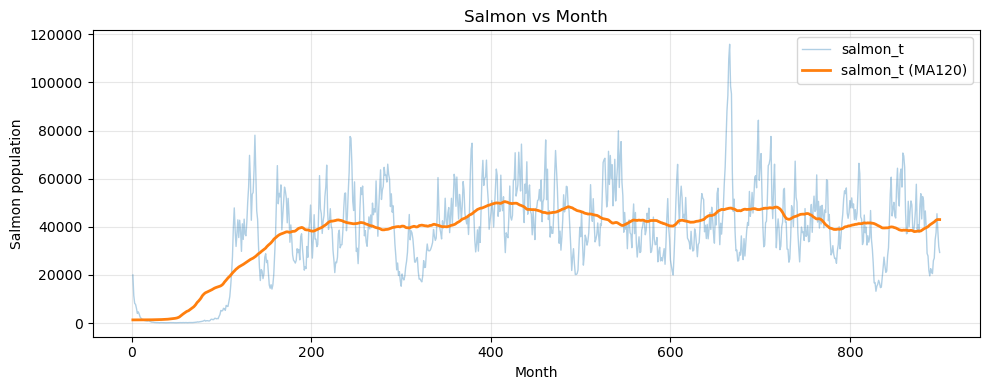

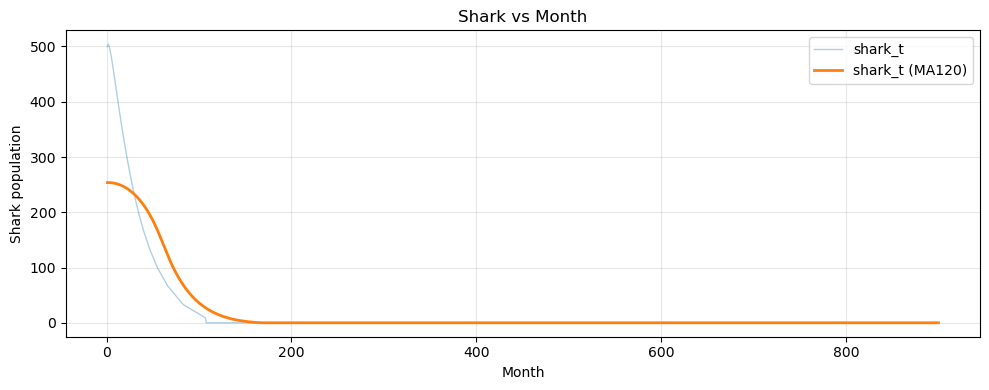

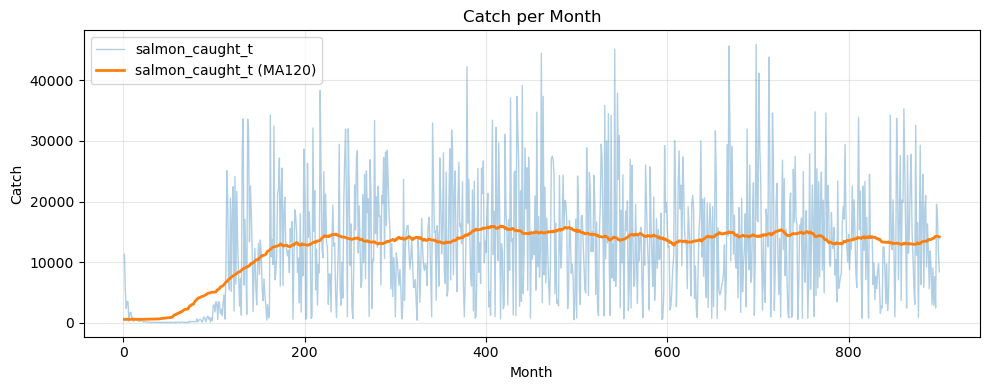

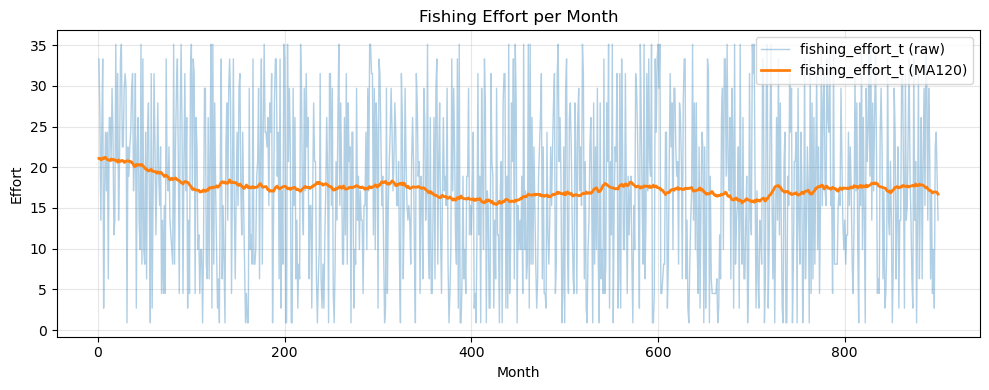

In [138]:
# --- buffers ---
months = []
salmon_hist = []
shark_hist = []
effort_hist = []
caught_hist = []

# --- initial state (set yours here) ---
salmon_t = float(agent_onp.salmon_t0)
shark_t  = float(agent_onp.shark_t0)

total_salmon_caught = 0.0
total_effort = 0.0

# --- rollout ---
for month_t in range(1, 901):
    fishing_effort_t = agent_onp.act((salmon_t, shark_t, month_t))
    salmon_caught_t, salmon_t_plus_1, shark_t_plus_1 = query(salmon_t, shark_t, fishing_effort_t, month_t)

    # record
    months.append(month_t)
    salmon_hist.append(salmon_t)
    shark_hist.append(shark_t)
    effort_hist.append(fishing_effort_t)
    caught_hist.append(salmon_caught_t)

    # accumulate
    total_salmon_caught += float(salmon_caught_t)
    total_effort += float(fishing_effort_t)

    # advance
    salmon_t, shark_t = float(salmon_t_plus_1), float(shark_t_plus_1)

K1, K2, K3, K4 = 0.001, 0.01, 100, 100
G = K1*total_salmon_caught - K2*total_effort + K3*np.log(salmon_t+1e-10) + K4*np.log(shark_t+1e-10)

print(f"Total Expected Return: {G}"), 
print(f"Total Salmon Caught: {total_salmon_caught}, Total Effort: {total_effort}, Salmon at the 75th year: {salmon_t}, Shark at the 75th year: {shark_t}")
# =============== helpers ===============
def _to_float_array(seq):
    """Safely convert a sequence to float np.array."""
    arr = np.asarray(seq, dtype=float)
    return arr

def _finite_mask(*arrays):
    """Return a boolean mask where all arrays are finite (no nan/inf)."""
    mask = np.ones_like(arrays[0], dtype=bool)
    for a in arrays:
        mask &= np.isfinite(a)
    return mask

def moving_average(x, window=12):
    """
    Centered moving average with reflection padding.
    Keeps length the same as x.
    """
    x = np.asarray(x, dtype=float)
    if window < 2:
        return x
    # reflect-pad on both sides so 'same' convolution is truly centered
    pad = window // 2
    x_pad = np.pad(x, (pad, pad), mode="reflect")
    kernel = np.ones(window, dtype=float) / window
    smoothed = np.convolve(x_pad, kernel, mode="same")[pad:-pad]
    return smoothed

# =============== prepare ===============
months_arr   = _to_float_array(months)
salmon_arr   = _to_float_array(salmon_hist)
shark_arr    = _to_float_array(shark_hist)
effort_arr   = _to_float_array(effort_hist)
caught_arr   = _to_float_array(caught_hist)

# clean each pair independently (so we don't drop points unnecessarily)
mask_salmon = _finite_mask(months_arr, salmon_arr)
mask_shark  = _finite_mask(months_arr, shark_arr)
mask_effort = _finite_mask(months_arr, effort_arr)
mask_catch  = _finite_mask(months_arr, caught_arr)

m_salmon, y_salmon = months_arr[mask_salmon], salmon_arr[mask_salmon]
m_shark,  y_shark  = months_arr[mask_shark],  shark_arr[mask_shark]
m_effort, y_effort = months_arr[mask_effort], effort_arr[mask_effort]
m_catch,  y_catch  = months_arr[mask_catch],  caught_arr[mask_catch]

# smooth fishing effort (choose window; 12 = ~1 year)
SMOOTH_WIN = 120
y_effort_smooth = moving_average(y_effort, window=SMOOTH_WIN)
y_catch_smooth = moving_average(y_catch, window=SMOOTH_WIN)
y_shark_smooth = moving_average(y_shark, window=SMOOTH_WIN)
y_salmon_smooth = moving_average(y_salmon, window=SMOOTH_WIN)

# =============== plots ===============

# 1) Salmon only
plt.figure(figsize=(10, 4))
plt.plot(m_salmon, y_salmon, label="salmon_t", alpha=0.35, linewidth=1.0)
plt.plot(m_shark, y_salmon_smooth, label=f"salmon_t (MA{SMOOTH_WIN})", linewidth=2.0)
plt.title("Salmon vs Month")
plt.xlabel("Month")
plt.ylabel("Salmon population")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Shark only
plt.figure(figsize=(10, 4))
plt.plot(m_shark, y_shark, label="shark_t", alpha=0.35, linewidth=1.0)
plt.plot(m_shark, y_shark_smooth, label=f"shark_t (MA{SMOOTH_WIN})", linewidth=2.0)
plt.title("Shark vs Month")
plt.xlabel("Month")
plt.ylabel("Shark population")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 3) Catch only
plt.figure(figsize=(10, 4))
plt.plot(m_catch, y_catch, label="salmon_caught_t", alpha=0.35, linewidth=1.0)
plt.plot(m_catch, y_catch_smooth, label=f"salmon_caught_t (MA{SMOOTH_WIN})", linewidth=2.0)
plt.title("Catch per Month")
plt.xlabel("Month")
plt.ylabel("Catch")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4) Effort only (raw + smoothed)
plt.figure(figsize=(10, 4))
# raw (fainter)
plt.plot(m_effort, y_effort, label="fishing_effort_t (raw)", alpha=0.35, linewidth=1.0)
# smoothed (emphasis)
plt.plot(m_effort, y_effort_smooth, label=f"fishing_effort_t (MA{SMOOTH_WIN})", linewidth=2.0)
plt.title("Fishing Effort per Month")
plt.xlabel("Month")
plt.ylabel("Effort")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
